In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score

In [2]:
users = pd.read_csv('takehome_users.csv', parse_dates = ['creation_time'])
user_eng = pd.read_csv('takehome_user_engagement.csv',  parse_dates = ['time_stamp'])

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
user_eng.user_id.nunique()

8823

In [9]:
#Converting the last_session_creation_time column in the users column to datetime.
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'] ,unit='s')
print(users.last_session_creation_time.dtypes)
users.head(3)

datetime64[ns]


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0


In [10]:
print(users['creation_time'].min(), users['creation_time'].max())
print(users['last_session_creation_time'].min(), users['last_session_creation_time'].max())

2012-05-31 00:43:27 2014-05-30 23:59:19
2012-05-31 08:20:06 2014-06-06 14:58:50


In [11]:
def rolling_count(df_group, frequency):
    return df_group.rolling(frequency, on='date')['user_id'].count()

In [12]:
df = user_eng.copy()
df['date'] = pd.to_datetime(df.time_stamp.dt.date)
df['visits_7_days'] = df.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')
df

,time_stamp,user_id,visited,date,visits_7_days
0,2014-04-22 03:53:30,1,1,2014-04-22,1.0
1,2013-11-15 03:45:04,2,1,2013-11-15,1.0
2,2013-11-29 03:45:04,2,1,2013-11-29,1.0
3,2013-12-09 03:45:04,2,1,2013-12-09,1.0
4,2013-12-25 03:45:04,2,1,2013-12-25,1.0
...,...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,2013-09-06,1.0
207913,2013-01-15 18:28:37,11997,1,2013-01-15,1.0
207914,2014-04-27 12:45:16,11998,1,2014-04-27,1.0
207915,2012-06-02 11:55:59,11999,1,2012-06-02,1.0


In [13]:
df.describe()

,user_id,visited,visits_7_days
count,207917.000000,207917.0,207917.000000
mean,5913.314197,1.0,4.381393
std,3394.941674,0.0,2.042666
min,1.000000,1.0,1.000000
25%,3087.000000,1.0,3.000000
50%,5682.000000,1.0,4.000000
75%,8944.000000,1.0,6.000000
max,12000.000000,1.0,7.000000


In [14]:
df[df.visits_7_days >= 3.0]

,time_stamp,user_id,visited,date,visits_7_days
9,2014-02-09 03:45:04,2,1,2014-02-09,3.0
10,2014-02-13 03:45:04,2,1,2014-02-13,3.0
27,2013-02-19 22:08:03,10,1,2013-02-19,3.0
30,2013-03-02 22:08:03,10,1,2013-03-02,3.0
31,2013-03-05 22:08:03,10,1,2013-03-05,3.0
...,...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,2014-05-23,6.0
207899,2014-05-24 11:04:47,11988,1,2014-05-24,6.0
207900,2014-05-26 11:04:47,11988,1,2014-05-26,5.0
207901,2014-05-27 11:04:47,11988,1,2014-05-27,5.0


In [21]:
user_adopted = df.groupby('user_id')['visits_7_days'].max().reset_index()
user_adopted['adopted_user'] = user_adopted['visits_7_days'].apply(lambda x: 1 if x>=3 else 0)
user_adopted.head()


,user_id,visits_7_days,adopted_user
0,1,1.0,0
1,2,3.0,1
2,3,1.0,0
3,4,1.0,0
4,5,1.0,0


In [22]:
user_adopted.adopted_user.value_counts()

0    7221
1    1602
Name: adopted_user, dtype: int64

In [24]:
user_adopted.drop('visits_7_days', axis = 1, inplace = True)
user_adopted.rename(columns={"user_id": "object_id"}, inplace=True)
user_adopted

,object_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
8818,11996,0
8819,11997,0
8820,11998,0
8821,11999,0


In [25]:
user_adopted.set_index("object_id", inplace = True)
user_adopted

,adopted_user
object_id,
1,0
2,1
3,0
4,0
5,0
...,...
11996,0
11997,0
11998,0


In [26]:
df_users = users.join(user_adopted, on = 'object_id', how='left')
print(df_users.shape)
df_users.head()

(12000, 11)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [27]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [28]:
# filling the missing values
df_users['last_session_creation_time'].fillna(0, inplace = True)
df_users['adopted_user'].fillna(0, inplace = True)
df_users.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145,0.133500
std,3464.24595,0.432742,0.356432,124.056723,3383.761968,0.340128
min,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000,1.000000


In [29]:
# extract useful information from the email variable like it's domain
df_users['email_domain'] = df_users.email.apply(lambda x: x.split('@')[1])
df_users['email_domain'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
qhoyb.com            1
uigit.com            1
nsxoy.com            1
lyoxx.com            1
sqclx.com            1
Name: email_domain, Length: 1184, dtype: int64

In [30]:
# Also checking the creation_source for NON NULL invited_by_user column
df_users[~df_users.invited_by_user_id.isnull()].creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE'], dtype=object)

In [34]:
#There are too many email domains and most of them seem fake domains so it's good to drop the column entirely.
#We can also drop the name and object_id columns.
df_users.drop(['object_id', 'name', 'email', 'email_domain'], axis = 1, inplace = True)

In [35]:
#And for the invited_by_user_id let's convert the NULL values to 0
#because the column has a Non Null value only if the creation_source was a GUEST_INVITE or a ORG_INVITE anyways.
df_users.invited_by_user_id.fillna(0, inplace=True)

In [36]:
#For the creation_time column let's add a column which calculates how old the account is,
#i.e. the number of days since the account was created.
df_users['days_since_creation'] = (user_eng.time_stamp.max() - df_users.creation_time).dt.days

In [37]:
# last_session_creation_time can be removed as well because it was in a sense used to create the adopted_user column.
df_users.drop(['creation_time', 'last_session_creation_time'], axis = 1, inplace = True)

In [38]:
# OneHotEncode the creation_source column
df_users = pd.get_dummies(df_users, columns=['creation_source'])

In [39]:
df_users.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_creation,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,141.884583,3188.691333,0.133500,324.568000,0.180250,0.354500,0.175917,0.173917,0.115417
std,0.432742,0.356432,124.056723,3869.027693,0.340128,216.646173,0.384412,0.478381,0.380765,0.379054,0.319537
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,29.000000,0.000000,0.000000,129.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,108.000000,875.000000,0.000000,304.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,238.250000,6317.000000,0.000000,506.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,1.000000,736.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
df_users.corr()['adopted_user']

opted_in_to_mailing_list              0.008097
enabled_for_marketing_drip            0.004653
org_id                                0.064523
invited_by_user_id                    0.021596
adopted_user                          1.000000
days_since_creation                   0.088020
creation_source_GUEST_INVITE          0.045408
creation_source_ORG_INVITE           -0.007636
creation_source_PERSONAL_PROJECTS    -0.075817
creation_source_SIGNUP                0.009299
creation_source_SIGNUP_GOOGLE_AUTH    0.036119
Name: adopted_user, dtype: float64

In [46]:
def cv_optimize(model, parameters, Xtrain, ytrain, n_folds = 5):
    """
    Cross validation. Function to hypertune the model "model" with the input paramete distribution using
    "parameters" on the training data.
    The output will be the best estimator whose average score on all folds will be best. 
    """
    clf = GridSearchCV(model, param_grid = parameters, cv = n_folds, scoring = 'accuracy')
    t0 = time.time()
    clf.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print('\n\n\n=============================',type(model).__name__,'=================================\n')
    print("It takes %.3f seconds for tuning " % (time_fit))
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best
    
def do_classify(model, parameters, df, targetname, scale = True, cols_to_transform = 'numeric', 
                featurenames = 'all', train_size = 0.8):
      
    # Creating the X and y variables for our model
    if featurenames == 'all':
        X = df.drop([targetname], axis = 1)
    else:
        X = df[featurenames]
        
    y = df[targetname]
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)

    model = cv_optimize(model, parameters, Xtrain, ytrain)
    t0 = time.time()
    model = model.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print("It takes %.3f seconds for fitting" % (time_fit))
    training_accuracy = model.score(Xtrain, ytrain)
    test_accuracy = model.score(Xtest, ytest)
    precision = precision_score(ytest, model.predict(Xtest))
    recall = recall_score(ytest, model.predict(Xtest))
    AUC = roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])
            
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print("Precision on test data:    {:0.2f}".format(precision))
    print("Recall on test data:       {:0.2f}".format(recall))
    print("AUC on test data:          {:0.2f}".format(AUC))
    print("=======Confusion Matrix=========")
    print(confusion_matrix(ytest, model.predict(Xtest)))
    print("=======Classification report=======")
    print(classification_report(ytest, model.predict(Xtest)))
    print("="*100)
    print("="*100)
    print("="*100)
    return model, Xtrain, ytrain, Xtest, ytest


In [47]:
# Random Forest model
model_rf = RandomForestClassifier(class_weight='balanced') # adding balanced to handle the unbalanced data
parameters_rf = {
                 'n_estimators': [10, 25, 50, 75, 100],
                 'criterion': ["gini", "entropy"],
                 'max_depth': [3, 6, 10, 12],
                 'max_features': ['auto', 'sqrt']
                }

In [49]:
model_rf, Xtrain, ytrain, Xtest, ytest = do_classify(model_rf, parameters_rf, 
                                                                  df_users, targetname = 'adopted_user')





============================= RandomForestClassifier =================================

It takes 92.209 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 25}
It takes 0.149 seconds for fitting
Accuracy on training data: 0.80
Accuracy on test data:     0.70
Precision on test data:    0.20
Recall on test data:       0.39
AUC on test data:          0.63
=======Confusion Matrix=========
[[1551  521]
 [ 199  129]]
=======Classification report=======
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81      2072
         1.0       0.20      0.39      0.26       328

    accuracy                           0.70      2400
   macro avg       0.54      0.57      0.54      2400
weighted avg       0.79      0.70      0.74      2400



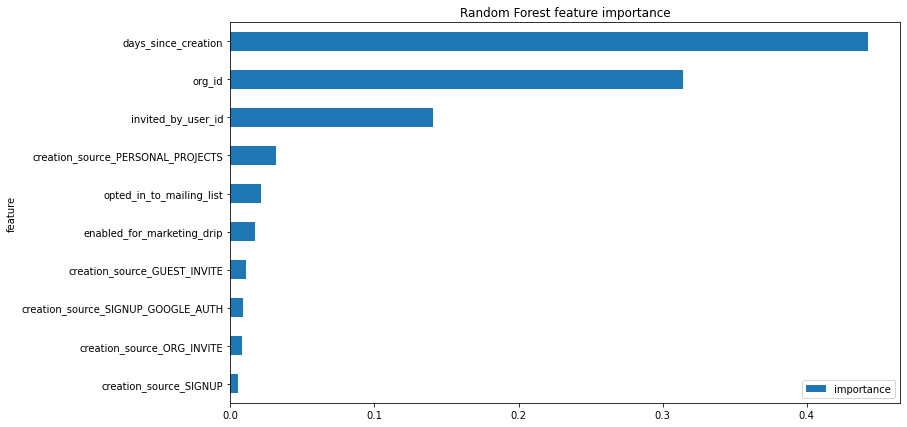

In [50]:
feat_imp = pd.DataFrame({'importance':model_rf.feature_importances_})    
feat_imp['feature'] = Xtrain.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))

The top 5 important features seem to be:

1- days_since_creation

2- org_id

3- invited_by_user_id

4- creation_source_PERSONAL_PROJECTS

5- opted_in_to_mailing_list

Furture possible work: We can also add a feature which calculates the difference between the creation date of the account and the first login of the user.